In [1]:
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
import tqdm
import sys
import torch
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"
print("device =", device)

device = cpu


In [2]:

def load_data(in_path):
    pball = {"m": [], "d": [], "y": [], "num": [], "pball": [], "pplay": []}
    with open(in_path, "r") as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0

        # headers = ["type", "month", "day", "year", "1", "2", "3", "4", "5", "powerball", "powerplay"]
        for row_idx, row_str in enumerate(csv_reader):
            row = [int(row_str[i]) for i in range(1, len(row_str))]
            row.insert(0, None)

            month = row[1]
            day = row[2]
            year = row[3]

            """
            Beginning with the October 31, 2017 drawing, 
            the game matrix changed from "1 to 75" white balls to "1 to 70" white balls, 
            and from "1 to 15" Mega Balls to "1 to 25" Mega Balls.
            """
            if year < 2017:
                continue
            elif year == 2017 and month < 10:
                continue
            elif year == 2017 and month == 10 and day < 31:
                continue
            numbers = [row[4], row[5], row[6], row[7], row[8]]
            powerball = row[9]
            if len(row) == 11:
                powerplay = row[10]
            else:
                assert False
                powerplay = 1

            pball["y"].append(year)
            pball["m"].append(month)
            pball["d"].append(day)
            pball["num"].append(numbers)
            pball["pball"].append(powerball)
            pball["pplay"].append(powerplay)

        for k, v in pball.items():
            pball[k] = np.array(v).astype(int)
            print(k, ":", pball[k].shape)
        print()
    return pball

# in_dir = "/content/drive/MyDrive/Colab Notebooks/220110_Lottery/inputs"
in_dir = "inputs"
in_path = os.path.join(in_dir, "megamillions_2003_2022.csv")
pball = load_data(in_path)

def parse_data(pball):
    outputs = []
    inputs = []
    seq_length = len(pball["y"])
    for i in range(seq_length):
        num = pball["num"][i]
        num_pball = pball["pball"][i]
        output = list(num)
        output.append(num_pball)
        outputs.append(output)

        year = pball["y"][i]
        month = pball["m"][i]
        day = pball["d"][i]

        # min-max normalize [0, 1]
        y = (year-2017) / (2022-2017)
        m = (month) / 12
        d = (day) / 31

        flag_y = float((year % 2) == 0)
        flag_m = float((month & 2) == 0)
        flag_d = float((day & 2) == 0)

        inputs.append([y, m, d, flag_y, flag_m, flag_d])
    outputs = np.float32(outputs)
    inputs = np.float32(inputs)
    return inputs, outputs

inputs, outputs = parse_data(pball)
print("input:", inputs.shape, ", outputs:", outputs.shape)

def one_hot_encode(y, num_classes):
    # y: (seq_length, num_classes)
    seq_length = y.shape[0]
    ys = np.zeros((seq_length, num_classes)).astype(np.float32)
    for s in range(seq_length):
        for c in range(len(y[s])):
            ys[s, int(y[s, c])-1] = 1.0
    return ys

outputs_num = one_hot_encode(outputs[:, 0:5], 70)
outputs_pball = one_hot_encode(outputs[:, 5][:, None], 25)

inputs = torch.Tensor(inputs).to(device)
outputs_num = torch.Tensor(outputs_num).to(device)
outputs_pball = torch.Tensor(outputs_pball).to(device)
print("\none hot encoded")
print("  - num  :", outputs_num.shape)
print("  - pball:", outputs_pball.shape)

m : (439,)
d : (439,)
y : (439,)
num : (439, 5)
pball : (439,)
pplay : (439,)

input: (439, 6) , outputs: (439, 6)

one hot encoded
  - num  : torch.Size([439, 70])
  - pball: torch.Size([439, 25])


In [3]:
numbers = {}
powerballs = {}
for i in range(0, len(pball["y"])):
    nums = pball["num"][i]
    p = pball["pball"][i]
    for n in nums:
        if n not in numbers:
            numbers[n] = 1
        else:
            numbers[n] += 1
        
    if p not in powerballs:
        powerballs[p] = 1
    else:
        powerballs[p] += 1

y = []
x = []
for k in sorted(numbers.keys()):
    n = numbers[k]
    x.append(k)
    y.append(n)

px = []
py = []
for k in sorted(powerballs.keys()):
    px.append(k)
    py.append(powerballs[k])

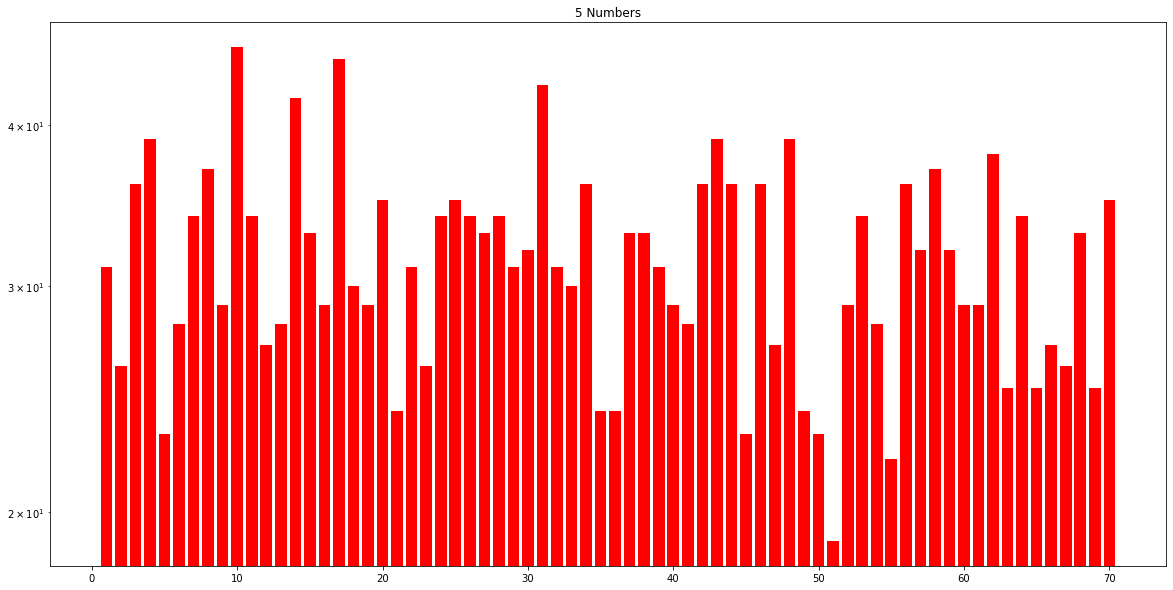

In [9]:
plt.figure(figsize=(20, 10))
plt.bar(x, y, color='r')
plt.title("5 Numbers")
plt.yscale("log")
plt.show()

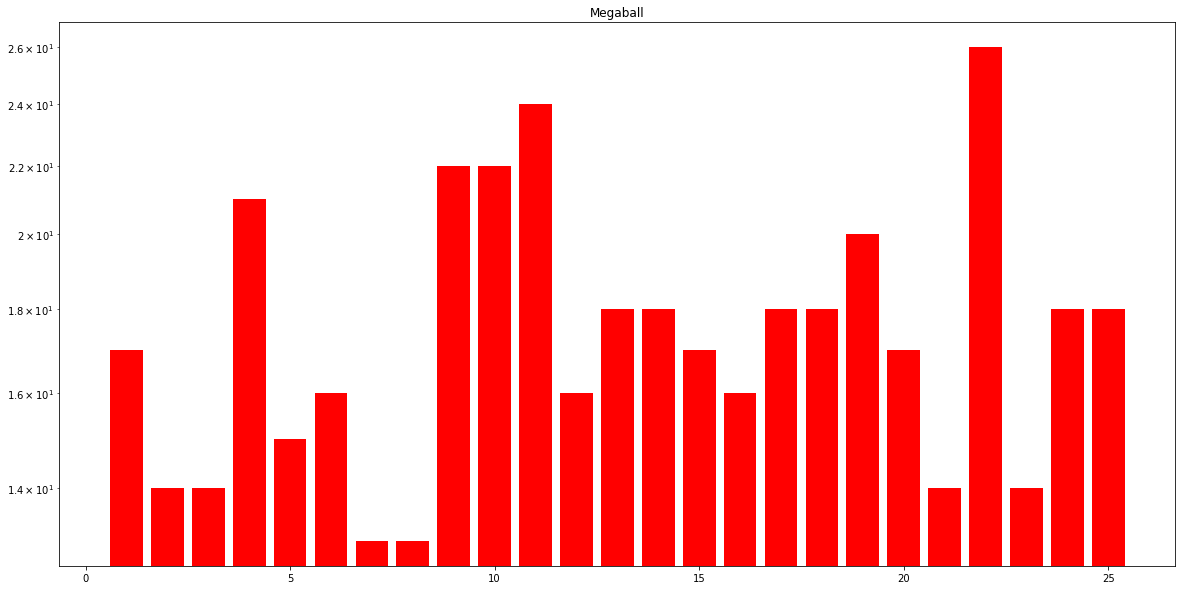

In [8]:
plt.figure(figsize=(20, 10))
plt.bar(px, py, color='r')
plt.title("Megaball")
plt.yscale("log")
plt.show()

# Even/odd

In [10]:
x = [0, 1]
y = [0, 0]
for k in sorted(numbers.keys()):
    n = numbers[k]
    v = int((n%2)==0)
    y[v] += 1
    
px = [0, 1]
py = [0, 0]
for k in sorted(powerballs.keys()):
    v = int((powerballs[k]%2)==0)
    py[v] += 1
        


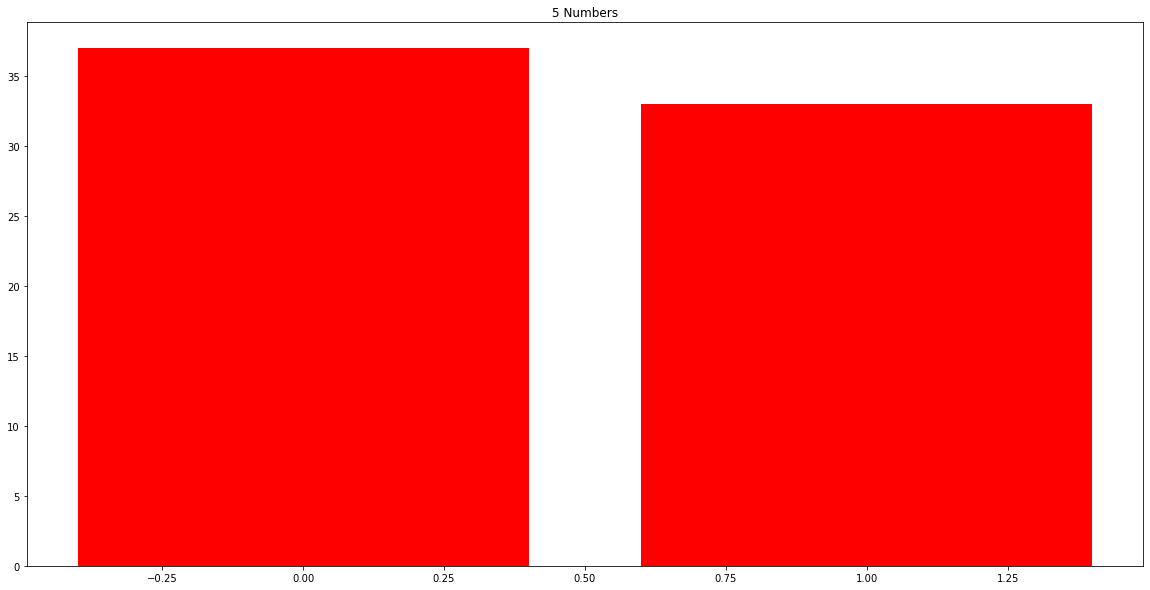

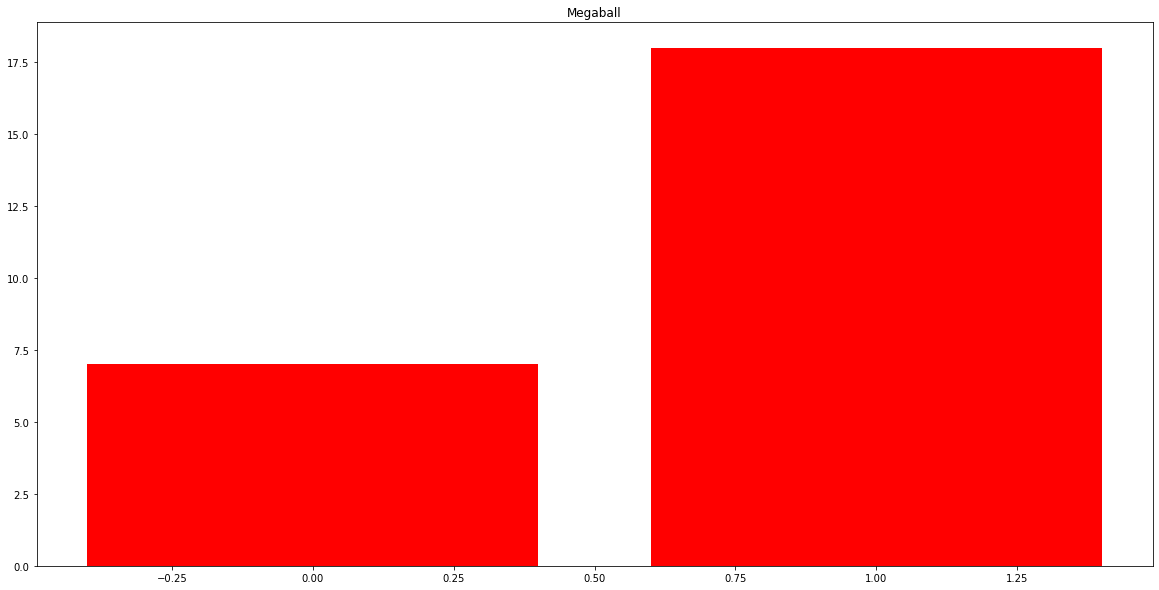

In [11]:
plt.figure(figsize=(20, 10))
plt.bar(x, y, color='r')
plt.title("5 Numbers")
plt.show()
plt.figure(figsize=(20, 10))
plt.bar(px, py, color='r')
plt.title("Megaball")
plt.show()

# check duplicate

In [14]:
number_sets = []
for i in range(len(pball["y"])):
    numbers = pball["num"][i].tolist()
    number_sets.append(numbers)
number_sets = set(frozenset(i) for i in number_sets)
print(number_sets)

{frozenset({65, 34, 44, 12, 47}), frozenset({43, 16, 20, 25, 30}), frozenset({34, 52, 58, 59, 62}), frozenset({64, 36, 16, 54, 61}), frozenset({3, 4, 39, 10, 58}), frozenset({6, 7, 14, 59, 28}), frozenset({66, 35, 28, 30, 31}), frozenset({7, 43, 56, 25, 59}), frozenset({40, 41, 52, 56, 25}), frozenset({64, 33, 47, 58, 59}), frozenset({11, 43, 17, 55, 31}), frozenset({39, 17, 21, 56, 29}), frozenset({5, 11, 14, 23, 25}), frozenset({66, 43, 44, 47, 22}), frozenset({65, 7, 10, 12, 61}), frozenset({32, 65, 39, 15, 50}), frozenset({64, 42, 28, 24, 60}), frozenset({5, 8, 10, 48, 17}), frozenset({11, 46, 59, 28, 31}), frozenset({4, 7, 13, 16, 60}), frozenset({8, 43, 22, 56, 29}), frozenset({66, 58, 22, 26, 27}), frozenset({2, 3, 19, 52, 58}), frozenset({34, 3, 6, 54, 63}), frozenset({68, 4, 9, 42, 62}), frozenset({53, 22, 55, 56, 30}), frozenset({38, 8, 16, 61, 30}), frozenset({7, 8, 39, 26, 30}), frozenset({33, 68, 45, 26, 61}), frozenset({38, 47, 15, 25, 26}), frozenset({66, 9, 14, 26, 29})

In [18]:
def check_dup(number_sets, number_list):
    n = frozenset(number_list)
    return (n in number_sets)

# n = [4, 6, 33, 32, 19]
n = [10, 14, 17,  31, 48]
exists = check_dup(number_sets, n)
print("{} => duplicate: {}".format(n, exists))

[10, 14, 17, 31, 48] => duplicate: False
